In [1]:
from __future__ import division
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages


plt.style.use('ggplot')
%matplotlib inline

In [2]:
def plot_2_potentials(phi1, phi2):
    x_label='x'
    y_label='y'
    z_label=''
    plt.figure(figsize=(15,4))
    subplots_x = 38
    ax1 = plt.subplot2grid((1,subplots_x), (0,0), colspan=10)
    s1 = ax1.imshow(phi1, 
                    origin='lower', interpolation='none')
    plt.title(z_label + ' 1', fontsize=20)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)

    ax3 = plt.subplot2grid((1,subplots_x), (0,10))
    cbar1 = plt.colorbar(s1, cax=ax3)
    cbar1.set_label(z_label, fontsize=18)

    ax2 = plt.subplot2grid((1,subplots_x), (0,13), colspan=10, sharey=ax1)
    s2 = ax2.imshow(phi2, 
                    origin='lower', interpolation='none')
    plt.title(z_label + ' 2', fontsize=20)
    plt.xlabel(x_label, fontsize=18)

    ax4 = plt.subplot2grid((1,subplots_x), (0,23))
    cbar2 = plt.colorbar(s2, cax=ax4)
    cbar2.set_label(z_label, fontsize=18)
    plt.subplots_adjust(hspace=0)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.show()

In [3]:
def _read_data(filename):
    with open(filename, 'rb') as handle:
        res = pickle.load(handle)
    return res

def read_data_fixed_np(meshsizes, np, mode):
    ''' read and return data list for fixed np, the desired meshsizes'''
    data = []
    for nx in meshsizes:
        fn = 'nx=' + str(nx) + '-np=' + str(np) + '-mode=' + str(mode) + '.pickle'
        data.append(_read_data(fn))
    return data

def read_data_fixed_nx(nps, nx, mode):
    ''' read and return data list for fixed nx, the desired number of particles npsS'''
    data = []
    for np in nps:
        fn = 'nx=' + str(nx) + '-np=' + str(np) + '-mode=' + str(mode) + '.pickle'
        data.append(_read_data(fn))
    return data

In [4]:
def compare_phi(result1, result2):
    ''' Compare (&plot if results differ) the phi stored in the two dictionaries
    result1, result2'''
    for res in [result1, result2]:
        res['phi'] = res['phi'].reshape(res['info']['nx'],res['info']['nx'])
    if result1['phi'].shape != result2['phi'].shape:
        print('Phis have different dimensions, aborting. Phi1: ' + str(result1['phi'].shape) + ' ' +
             str(result2['phi'].shape))
        return
        
    if np.allclose(result1['phi'], result2['phi']):
        return True
    else:
        phi1 = result1['phi']
        phi2 = result2['phi']
        plot_2_potentials(phi1, phi2)
        return False
        
def check_results(dataseries):
    '''pass a list of data generated by a read_XPU_data_...() function and check whether the phis are the same
    '''
    refseries = dataseries[0]
    for data in dataseries:
        for idx, res in enumerate(data):
            if not compare_phi(res, refseries[idx]):
                print('Inconsistency in dataset, investigate')
                return False
    return True
    

In [343]:
# plotting stuff
#courtesy of stackoverflow, http://stackoverflow.com/questions/2739159/inserting-a-pdf-file-in-latex
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

def make_label_bigger(ax, fontsize=14):
    ''' sets xticks, yticks, xlabel, ylabel to fontsize'''
    for label in (ax.get_xticklabels() + ax.get_yticklabels() + [ax.xaxis.label] + [ax.yaxis.label]):
        label.set_fontsize(fontsize)

def __plot(xxs, yy, labels, ylabel, free_quantity, fixed_quantity, second_line=''):
    '''Second line refers to an optional second line of the xlabel'''
    f = plt.figure()
    ax = plt.subplot()
    for idx, times in enumerate(yy):
        plt.plot(xxs[idx], times, label=labels[idx], linewidth=2.)
    
    plt.legend(loc='best')
    plt.xlabel(free_quantity + ',    ' + second_line)
    plt.ylabel(ylabel)
    make_label_bigger(ax)
    plt.show()
    
def __plot_frac(x, yy, labels, free_quantity, fixed_quantity, second_line=''):
    f = plt.figure()
    ax = plt.subplot()
    print x
    print yy[0]        
    for idx, times in enumerate(yy):
        plt.plot(x, list(times), label=labels[idx], linewidth=2.)
    
    plt.legend(loc='best')
    plt.xlabel(free_quantity + ',    ' + second_line)
    plt.ylabel('fraction of time spent')
    make_label_bigger(ax)
    plt.show()

def __plot_with_speedup(xxs, yy, labels, ylabel, free_quantity, fixed_quantity, second_line=''):
    ''' plots the speedup of yy[0] vs yy[1] as barplot to a subplot on the right
    Only works for if len(yy) = 2!'''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    speed_0 = np.array(yy[0])
    speed_1 = np.array(yy[1])
    for idx, times in enumerate(yy):
        ax1.plot(xxs[idx], times, label=labels[idx], linewidth=2.)
    ax1.legend(loc='best')
    ax1.set_xlabel(free_quantity + ',    ' + second_line)
    ax1.set_ylabel(ylabel)
    
    left = np.arange(0., 1., 1./len(xxs[0]))
    height = speedup =  speed_0/speed_1
    wdth = (left[1]-left[0])/2.
    rects = ax2.bar(left, height, width=wdth, color=plt.rcParams['axes.color_cycle'][4])
    ax2.set_ylabel('Speedup')
    ax2.set_xticks(left+wdth/2.)
    ax2.set_xticklabels( [str(n) for n in xxs[0]])
    ax2.set_xlabel(free_quantity + ',    ' + second_line)
    y_lim_max = 1.15*max(speedup)
    ax2.set_ylim([0, y_lim_max])
    ax2.set_xlim([left[0]-wdth/2, 2*len(xxs[0])*wdth - wdth/2])
    def autolabel(rects): # http://matplotlib.org/examples/api/barchart_demo.html
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax2.text(rect.get_x()+rect.get_width()/2., 1.05*height, 'x ' + str(round(height,1)),
                    ha='center', va='bottom', fontsize=16)
    autolabel(rects)
    
    make_label_bigger(ax1)
    make_label_bigger(ax2)
    plt.show()

_plot = __plot #standard
    

def plot_timings(list_of_list_of_results, free_quantity='nx'):
    '''lor[0] corresponds to a single result stored in a pickle file
    free_quantity is either nx or n_particles
    '''
    if free_quantity == 'nx':
        fixed_quantity = 'n_particles'
    else:
        fixed_quantity = 'nx'
    
    xxs = [[x['info'][free_quantity] for x in l]
          for l in list_of_list_of_results]
    
    labels = [[res['info']['device'] + ' ' +
               str(res.get('info').get('permc_spec', '')) + ' ' +
               str(res.get('info').get('symmetrize', '')) + ' ' + str(res.get('info').get('solver', ''))
               for res in list_of_results]
                 for list_of_results in list_of_list_of_results]
    labels = [val[0] for val in labels]
    
    time_solve = [[res['timings']['time_solve'] for res in list_of_results]
                 for list_of_results in list_of_list_of_results]
    
    time_poisson_solve = [[res['timings']['time_poisson_solve'] for res in list_of_results]
             for list_of_results in list_of_list_of_results]
    
    time_p2m = [[res['timings']['time_p2m'] for res in list_of_results]
                 for list_of_results in list_of_list_of_results]
    
    time_m2p = [[res['timings']['time_m2p'] for res in list_of_results]
                 for list_of_results in list_of_list_of_results]
    
    time_init = [[res['timings']['time_init'] for res in list_of_results]
                 for list_of_results in list_of_list_of_results]
    
    time_init_and_solve = [[res['timings']['time_init']+res['timings']['time_solve'] for res in list_of_results]
                 for list_of_results in list_of_list_of_results]
    
    # fraction of time spent in m2p, p2m, solve
    t_total = [[res['timings']['time_poisson_solve'] +res['timings']['time_m2p'] +
                res['timings']['time_p2m']for res in list_of_results]
                for list_of_results in list_of_list_of_results]
    
    t_frac_m2p = [np.array(time_m2p[idx])/np.array(tot) for idx,tot in enumerate(t_total)]
    t_frac_p2m = [np.array(time_p2m[idx])/np.array(tot) for idx,tot in enumerate(t_total)]
    t_frac_poisson_solve = [np.array(time_poisson_solve[idx])/np.array(tot) for idx,tot in enumerate(t_total)]
    print t_frac_poisson_solve[0]

    __plot_frac(xxs[0], [t_frac_poisson_solve[0], t_frac_p2m[0], t_frac_m2p[0]], ['solve','p2m','m2p'] ,
                 free_quantity, fixed_quantity,
                 second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
                                                   for x in l for l in list_of_list_of_results][0])+ ' CPU')
    __plot_frac(xxs[1], [t_frac_poisson_solve[1], t_frac_p2m[1], t_frac_m2p[1]], ['solve','p2m','m2p'] ,
                 free_quantity, fixed_quantity,
                 second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
                                                   for x in l for l in list_of_list_of_results][0]) + ' GPU')
    
#     _plot([xxs[0], xxs[0], xxs[0]], time_solve, labels, 't[s] for solve(m2p, solve, p2m)', free_quantity, fixed_quantity, 
#           second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
#                                                    for x in l for l in list_of_list_of_results][0]))
    
    _plot(xxs, time_poisson_solve, labels, 't[s] for solve', free_quantity, fixed_quantity, 
          second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
                                                   for x in l for l in list_of_list_of_results][0]))
    
    _plot(xxs, time_p2m, labels, 't[s] for p2m', free_quantity, fixed_quantity,
          second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
                                                   for x in l for l in list_of_list_of_results][0]))
    
    _plot(xxs, time_m2p, labels, 't[s] for m2p', free_quantity, fixed_quantity,
          second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
                                                   for x in l for l in list_of_list_of_results][0]))
    
    _plot(xxs, time_init, labels, 't[s] for init', free_quantity, fixed_quantity,
          second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
                                                   for x in l for l in list_of_list_of_results][0]))
    _plot(xxs, time_init_and_solve, labels, 't[s] for solve incl. init', free_quantity, fixed_quantity,
          second_line=str(fixed_quantity) + '=' + str([res['info'][fixed_quantity] 
                                                   for x in l for l in list_of_list_of_results][0]))
    

    

In [344]:
# plot the fraction of timings...
cpu = read_data_fixed_np(nnx, 10*1000*1024, mode='CPU')
gpu = read_data_fixed_np(nnx, 10*1000*1024, mode='GPU')

    
# fraction of time spent in m2p, p2m, solving
t_total_CPU = [res['timings']['time_poisson_solve'] +res['timings']['time_m2p'] +
              res['timings']['time_p2m']for res in cpu]
t_total_GPU = [res['timings']['time_poisson_solve'] +res['timings']['time_m2p'] +
              res['timings']['time_p2m']for res in gpu]
print np.array([c['timings']['time_poisson_solve'] for c in cpu])/np.array(t_total_CPU)
print np.array([c['timings']['time_m2p'] for c in cpu])/np.array(t_total_CPU)
print np.array([c['timings']['time_p2m'] for c in cpu])/np.array(t_total_CPU)



[ 0.00760069  0.03035089  0.13052061  0.41971693]
[ 0.57873501  0.56698521  0.48741993  0.32594365]
[ 0.4136643   0.40266389  0.38205947  0.25433942]


In [345]:
nnx = [128, 256, 512, 1024]
nnp = [500*1024, 1000*1024, 2*1000*1024, 5*1000*1024, 10*1000*1024]

True
0.673664093018
0.181011915207
[ 0.00760069  0.03035089  0.13052061  0.41971693]
[128, 256, 512, 1024]
[ 0.00760069  0.03035089  0.13052061  0.41971693]


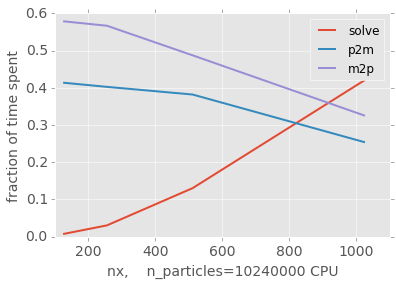

[128, 256, 512, 1024]
[ 0.00533411  0.0078461   0.01930791  0.05588   ]


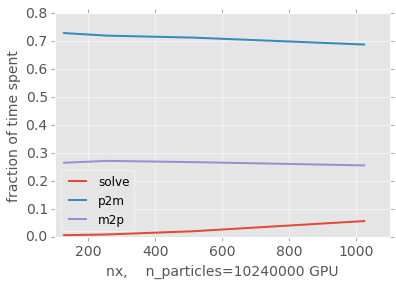

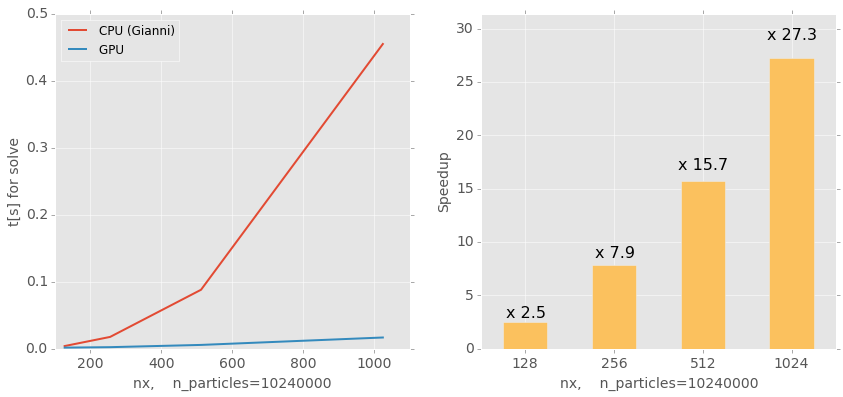

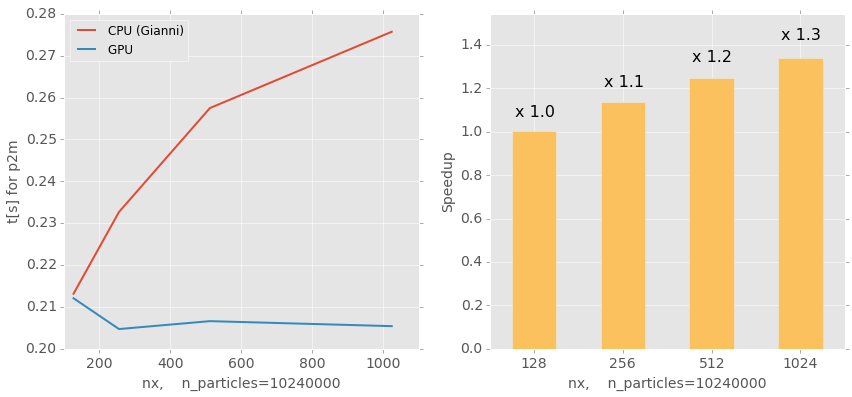

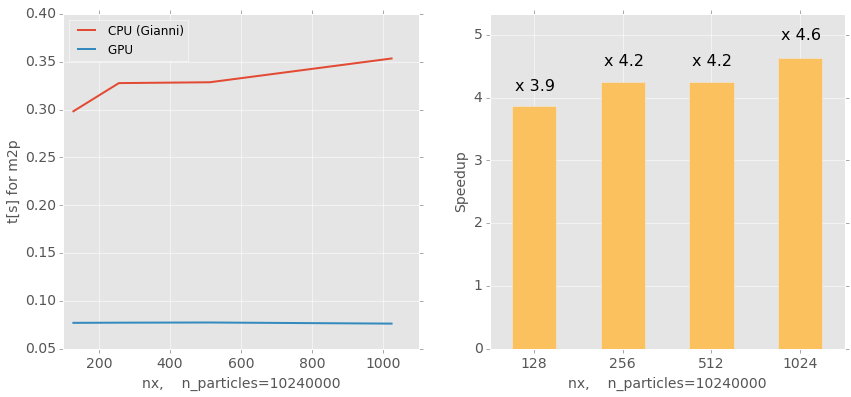

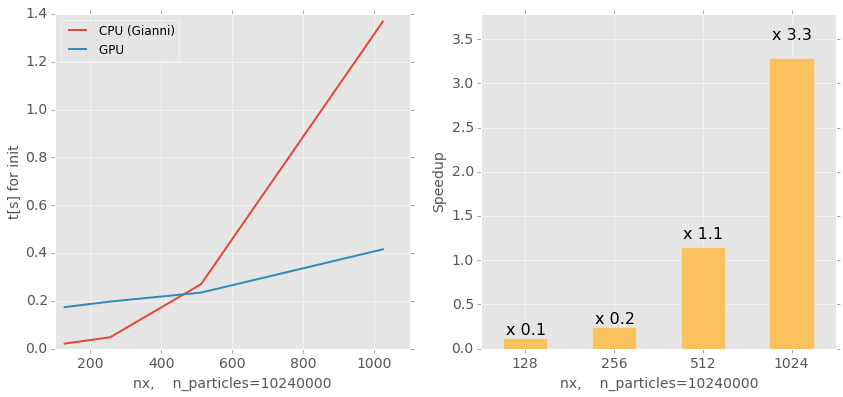

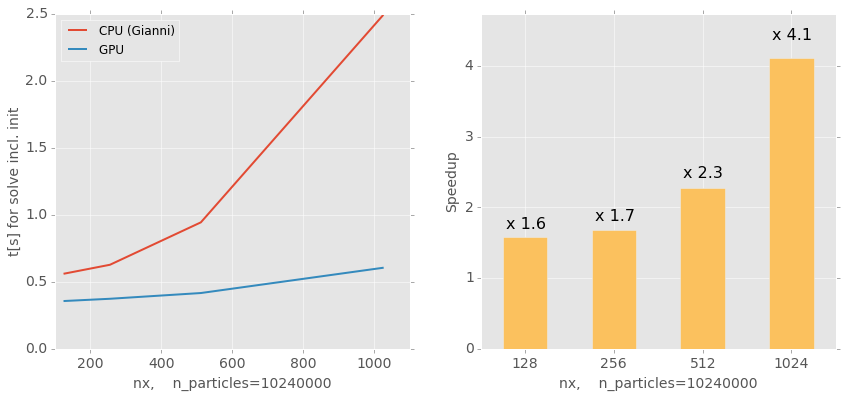

In [346]:
xx = read_data_fixed_np(nnx, 10*1000*1024, mode='CPU')
yy = read_data_fixed_np(nnx, 10*1000*1024, mode='GPU')

print check_results([xx, yy]) #True!
_plot = __plot_with_speedup
print xx[2]['timings']['time_solve']
print yy[2]['timings']['time_solve']
plot_timings([xx,yy], free_quantity='nx')

[ 0.89884256  0.84474433  0.76239828  0.58406636  0.41971693]
[512000, 1024000, 2048000, 5120000, 10240000]
[ 0.89884256  0.84474433  0.76239828  0.58406636  0.41971693]


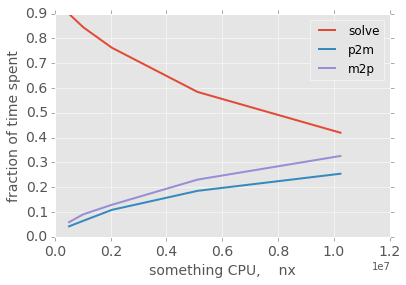

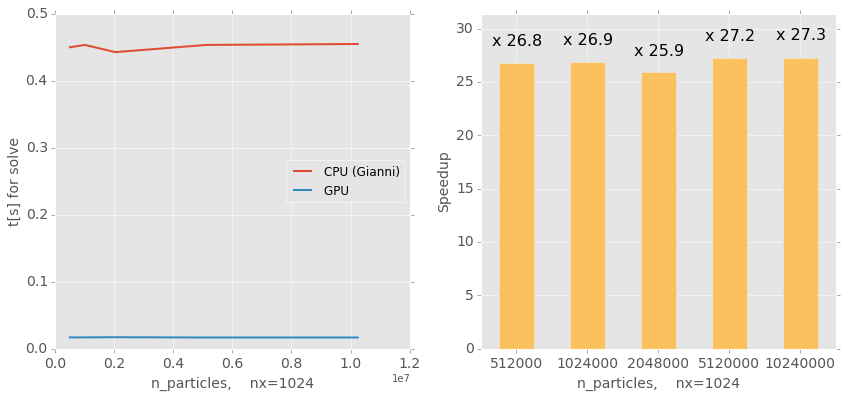

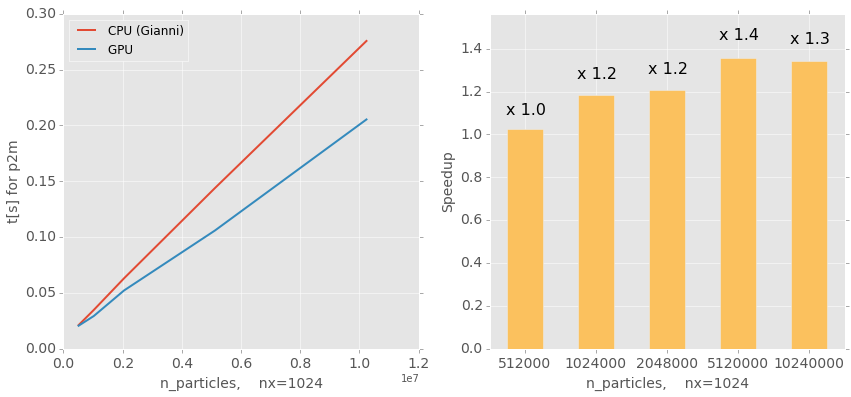

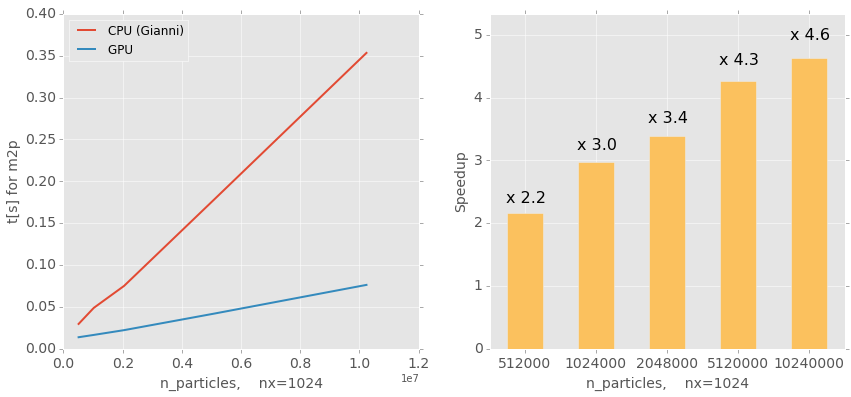

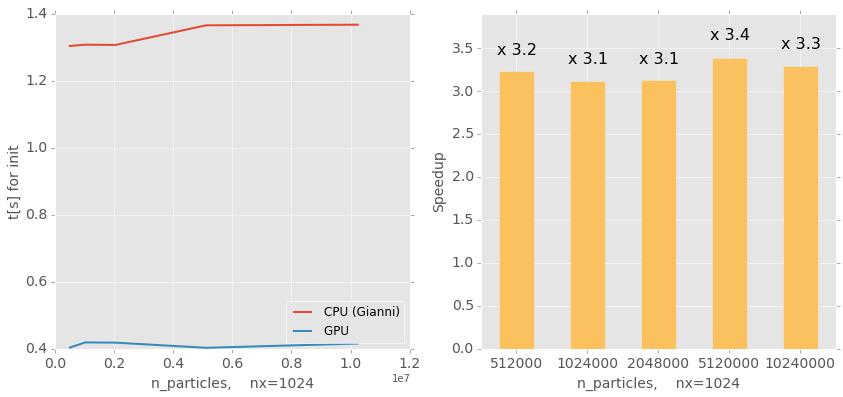

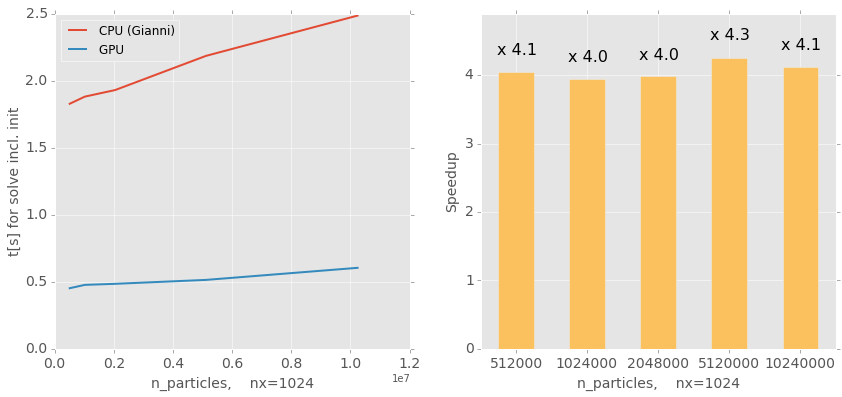

In [338]:

xx = read_data_fixed_nx(nnp, nnx[3], mode='CPU')
yy = read_data_fixed_nx(nnp, nnx[3], mode='GPU')
plot_timings([xx,yy], free_quantity='n_particles')

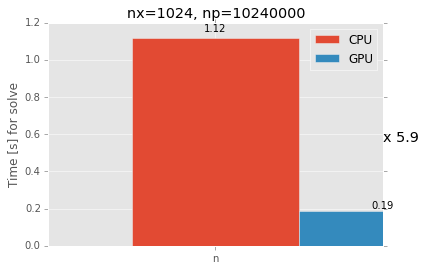

In [223]:
def plot_speedup(data_CPU, data_GPU):
    CPU_time = data_CPU['timings']['time_solve']
    GPU_time = data_GPU['timings']['time_solve']


    ind = 0.1*np.arange(1)  # the x locations for the groups
    width = 1
    fig, ax = plt.subplots()
    rects1 = ax.bar(0.5, CPU_time, width, color=plt.rcParams['axes.color_cycle'][0])


    rects2 = ax.bar(0.5+width, GPU_time, width)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Time [s] for solve')
    ax.set_title('nx=' + str(data_CPU['info']['nx']) + ', np=' + str(data_CPU['info']['n_particles']))
    ax.set_xticks(ind+width)
    ax.set_xticklabels('nx' )
    ax.set_xlim([0, 2*width])

    ax.legend( (rects1[0], rects2[0]), ('CPU', 'GPU') )

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.02*height, round(height,2),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # speedup label
    speedup = CPU_time/GPU_time
    ax.text(rects2[0].get_x()+rects2[0].get_width()/2., 0.5*rects1[0].get_height(), 'x ' +str(round(speedup,1)),
           fontsize='x-large')
    
    plt.show()
    
xx = read_data_fixed_nx(nnp, 1024, mode='CPU')
yy = read_data_fixed_nx(nnp, 1024, mode='GPU')
plot_speedup(xx[4], yy[4])

In [221]:

#multipage('multipage.pdf')